<a href="https://colab.research.google.com/github/AmirGhnbr/statistical_time_series_analysis/blob/main/statistical_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q seaborn arch yfinance scikit-learn pmdarima mplfinance sktime

In [2]:
!pip install git+https://github.com/statsmodels/statsmodels

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-gvvjcc31
  Running command git clone --filter=blob:none --quiet https://github.com/statsmodels/statsmodels /tmp/pip-req-build-gvvjcc31
  Resolved https://github.com/statsmodels/statsmodels to commit 3b61c469ed8d4a6752b5bf01390789512f81f0c6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mplf
import matplotlib.pyplot as plt

In [4]:
data = yf.download('BTC-USD',
                   period='9mo',
                   interval='1d',
                   progress=False)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-06,20161.039062,20408.392578,19900.087891,19955.443359,19955.443359,34711412966
2022-10-07,19957.558594,20041.085938,19395.792969,19546.849609,19546.849609,29227315390
2022-10-08,19546.328125,19601.695312,19299.414062,19416.568359,19416.568359,16437423167
2022-10-09,19417.478516,19542.539062,19349.259766,19446.425781,19446.425781,16837262532
2022-10-10,19446.416016,19515.466797,19102.978516,19141.484375,19141.484375,27425022774
...,...,...,...,...,...,...
2023-07-02,30587.269531,30766.140625,30264.019531,30620.769531,30620.769531,10533418042
2023-07-03,30624.515625,31375.613281,30586.513672,31156.439453,31156.439453,15271884873
2023-07-04,31156.865234,31325.197266,30659.355469,30777.582031,30777.582031,12810828427


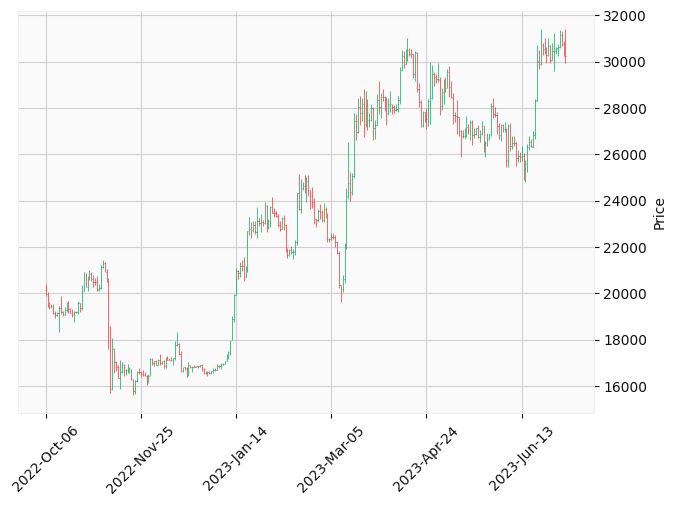

In [5]:
mplf.plot(data, style='yahoo',warn_too_much_data=10000)

### Trying to decompose the non-stationary btc data using stl

In [6]:
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

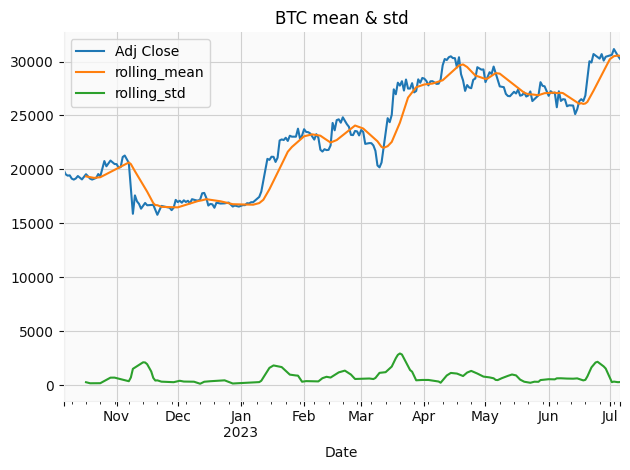

In [7]:
WINDOW_SIZE = 12
data["rolling_mean"] = data["Adj Close"].rolling(window=WINDOW_SIZE).mean()
data["rolling_std"] = data["Adj Close"].rolling(window=WINDOW_SIZE).std()
data[['Adj Close','rolling_mean','rolling_std']].plot(title="BTC mean & std")

sns.despine()
plt.tight_layout()

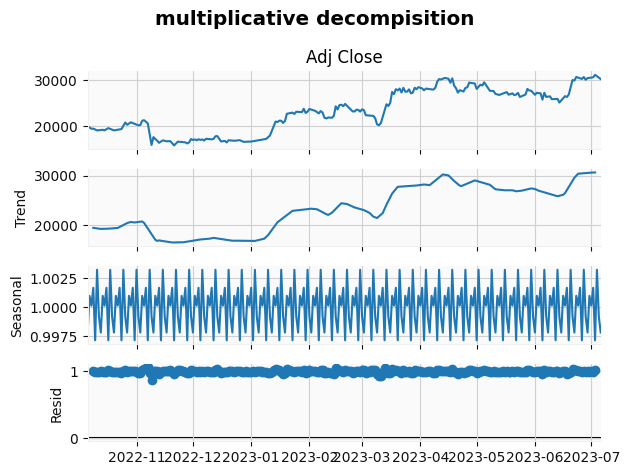

In [8]:
decomposition_res = seasonal_decompose(data['Adj Close'],model='multiplicative')

(
    decomposition_res
    .plot()
    .suptitle('multiplicative decompisition')
)
sns.despine()
plt.tight_layout()

### Let's do STL ans mstl decomposition

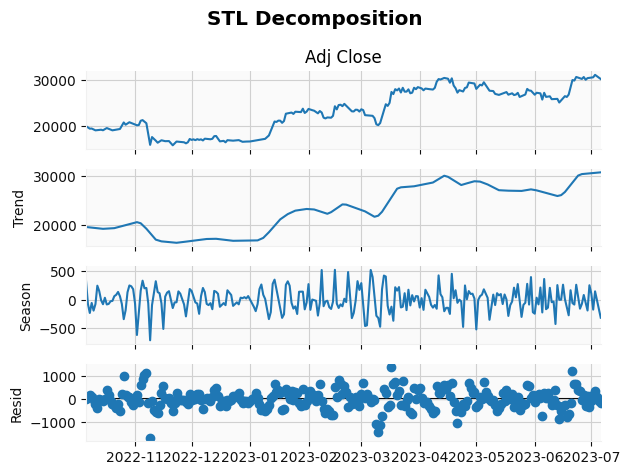

In [9]:
from statsmodels.tsa.seasonal import STL

stl_decomposition = STL(data["Adj Close"]).fit()
stl_decomposition.plot() \
                 .suptitle("STL Decomposition")

sns.despine()
plt.tight_layout()

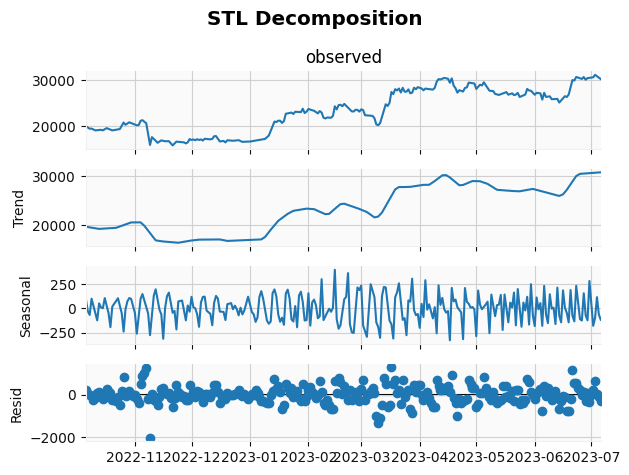

In [10]:
from statsmodels.tsa.seasonal import MSTL

stl_decomposition = MSTL(data["Adj Close"]).fit()
stl_decomposition.plot() \
                 .suptitle("STL Decomposition")

sns.despine()
plt.tight_layout()

## Apply hodrick-prescott filter

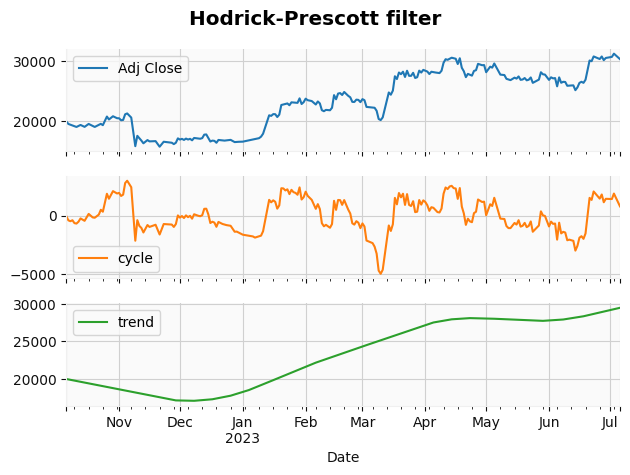

In [11]:
from statsmodels.tsa.filters.hp_filter import hpfilter

hp_df = data[["Adj Close"]].copy()
hp_df["cycle"], hp_df["trend"] = hpfilter(hp_df["Adj Close"], 129600)
hp_df.plot(subplots=True, title="Hodrick-Prescott filter");

sns.despine()
plt.tight_layout()

As you see BTC was finished a down trend in Dec and start new uptrend in Jan, and that trend finished in May , now new uptrend in BTC started at Jul as it was in Jan, expecting to have another 3.5 month uptrend

## Testing for Stationary in time series

Implement:

* Augmented Dickey-Fuller(ADF) test
* Kwiatkowski-philips-Schmidt-Shin (KPSS) test

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

> A unit root is a feature of a time series that makes it non-stationary, meaning that its statistical properties change over time.

> The ADF test is commonly used in econometrics and finance to test for the presence of a trend in a time series dataset. The null hypothesis of the ADF test is that the time series has a unit root, meaning that it is non-stationary.

In [13]:
def adf_test(x):
  indeces = ["Test Statistic", "p-value","# of Lags Used", "# of Observations Used"]

  adf_test = adfuller(x, autolag='AIC')
  results = pd.Series(adf_test[0:4],index = indeces)
  for key, value in adf_test[4].items():
    results[f"Critical Value ({key})"] = value
  return results

In [14]:
adf_test(data['Adj Close'])

Test Statistic             -0.606665
p-value                     0.869469
# of Lags Used              0.000000
# of Observations Used    273.000000
Critical Value (1%)        -3.454533
Critical Value (5%)        -2.872186
Critical Value (10%)       -2.572443
dtype: float64

the p-value in greater than the threshold value (0.05)

In [15]:
def kpss_test(x, h0_type="c"):
 indices = ["Test Statistic", "p-value", "# of Lags"]
 kpss_test = kpss(x, regression=h0_type);
 results = pd.Series(kpss_test[0:3], index=indices)

 for key, value in kpss_test[3].items():
    results[f"Critical Value ({key})"] = value
 return results

In [16]:
kpss_test(data['Adj Close'])

<ipython-input-15-ca4edb5552cd>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(x, regression=h0_type);


Test Statistic            2.18534
p-value                   0.01000
# of Lags                10.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64

* The null hypothesis of the kpss test states that the time series is stationary. With a p-value of 0.01 (less than the threshold 0.05) which rejects the hypothesis => time series is non-stationary


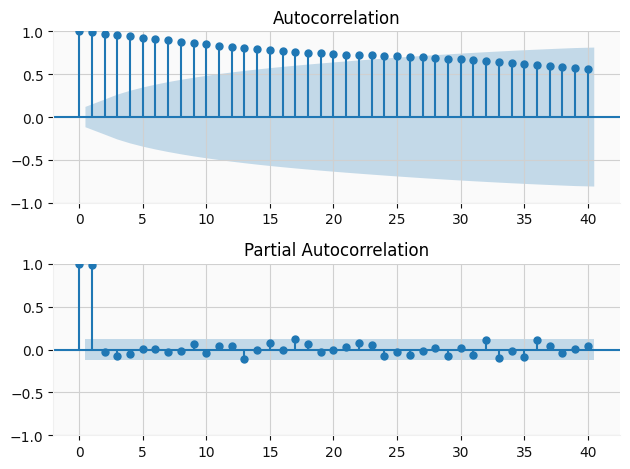

In [17]:
def plot_acf_pacf(data):
    N_LAGS= 40
    SIGNIFICANCE_LEVEL = 0.05

    fig, ax = plt.subplots(2, 1)
    plot_acf(data, ax=ax[0],lags=N_LAGS,
    alpha=SIGNIFICANCE_LEVEL);
    plot_pacf(data, ax=ax[1],lags=N_LAGS,
    alpha=SIGNIFICANCE_LEVEL);

    sns.despine()
    plt.tight_layout()


plot_acf_pacf(data['Adj Close'])

### Zivot Andrews test

In [18]:
from arch.unitroot import ZivotAndrews
za = ZivotAndrews(data['Adj Close'])
print(za.summary().as_text())

        Zivot-Andrews Results        
Test Statistic                 -3.316
P-value                         0.787
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


## Make time series stationary

Calculating the log-return of the data will make it a stationary

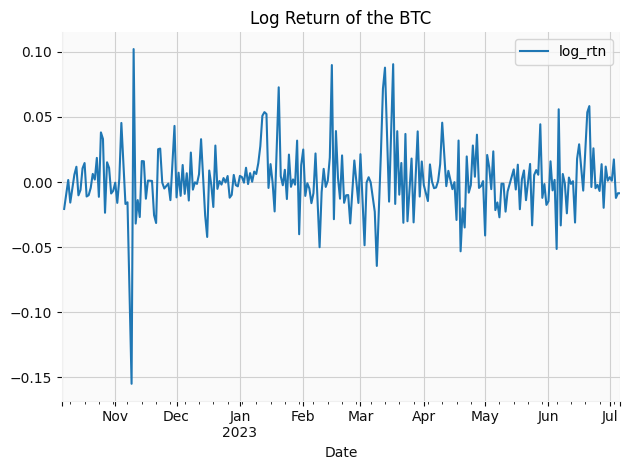

In [19]:
data['log_rtn']=np.log(data['Adj Close']/data['Adj Close'].shift(1))

(
    data.loc[:,['log_rtn']]
    .plot(title='Log Return of the BTC')
)
sns.despine()
plt.tight_layout()

In [20]:
from arch.unitroot import ADF
adf=ADF(data['log_rtn'].dropna())
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -15.866
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [21]:
adf_test(data['log_rtn'].dropna())

Test Statistic           -1.586595e+01
p-value                   9.097534e-29
# of Lags Used            0.000000e+00
# of Observations Used    2.720000e+02
Critical Value (1%)      -3.454622e+00
Critical Value (5%)      -2.872225e+00
Critical Value (10%)     -2.572464e+00
dtype: float64

In [22]:
kpss_test(data['log_rtn'].dropna())

<ipython-input-15-ca4edb5552cd>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(x, regression=h0_type);


Test Statistic           0.104446
p-value                  0.100000
# of Lags                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

the data is now stationary

## Modeling time series with exponential smoothing methods

In [23]:
from statsmodels.tsa.holtwinters import (ExponentialSmoothing,
                                         SimpleExpSmoothing,
                                         Holt)

In [24]:
train_size = int(0.8 * len(data['Adj Close'].dropna()))
test_len = len(data['Adj Close'].dropna())-train_size
df_train = data['Adj Close'].dropna().iloc[:train_size]
df_test = data['Adj Close'].dropna().iloc[train_size:]

In [25]:
ses_1 = SimpleExpSmoothing(df_train).fit(smoothing_level=0.5)
ses_forecast_1 = ses_1.forecast(test_len);

ses_2 = SimpleExpSmoothing(df_train).fit()
ses_forecast_2 = ses_2.forecast(test_len);

ses_1.params_formatted

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,name,param,optimized
smoothing_level,alpha,0.500000,False
initial_level,l.0,19955.443359,False


In [26]:
ses_1.summary()

Dep. Variable:,Adj Close,No. Observations:,219
Model:,SimpleExpSmoothing,SSE,112248615.982
Optimized:,False,AIC,2883.227
Trend:,None,BIC,2890.005
Seasonal:,None,AICC,2883.414
Seasonal Periods:,None,Date:,"Thu, 06 Jul 2023"
Box-Cox:,False,Time:,17:34:24
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,19955.443,l.0,False


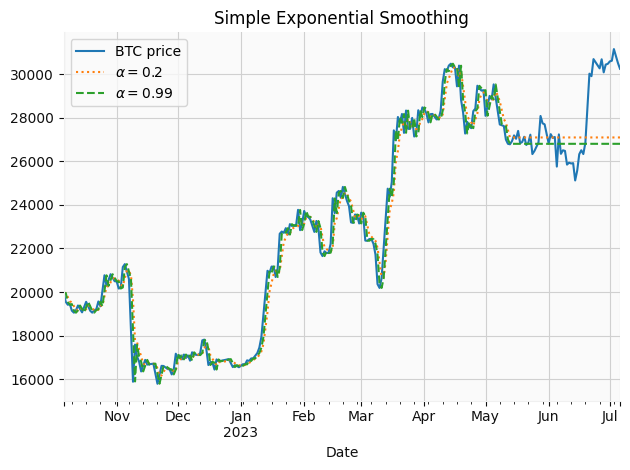

In [27]:
ses_df = data.copy()
ses_df["ses_1"] = pd.concat([ses_1.fittedvalues,ses_forecast_1])
ses_df["ses_2"] = pd.concat([ses_2.fittedvalues,ses_forecast_2])

opt_alpha = ses_2.model.params["smoothing_level"]

fig, ax = plt.subplots()
ses_df[['Adj Close','ses_1','ses_2']].plot(style=["-",":","--"], ax=ax,
                     title="Simple Exponential Smoothing")
labels = [
    "BTC price",
    r"$\alpha=0.2$",
    r"$\alpha={0:.2f}$".format(opt_alpha),
]
ax.legend(labels)

sns.despine()
plt.tight_layout()

fit 3 varriants of HOLT's linear trend model and create forecast

In [28]:
# Holt's model with linear trend
hs_1 = Holt(df_train).fit()
hs_forecast_1 = hs_1.forecast(test_len)

# Holt's model with exponential trend
hs_2 = Holt(df_train, exponential=True).fit()
# equivalent to ExponentialSmoothing(df_train, trend="mul").fit()
hs_forecast_2 = hs_2.forecast(test_len)

# Holt's model with exponential trend and damping
hs_3 = Holt(df_train, exponential=False,
            damped_trend=True).fit()
hs_forecast_3 = hs_3.forecast(test_len)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [29]:
hs_3.params_formatted

,name,param,optimized
smoothing_level,alpha,0.995000,True
smoothing_trend,beta,0.047381,True
initial_level,l.0,19955.443359,False
initial_trend,b.0,-404.507812,False
damping_trend,phi,0.990000,True


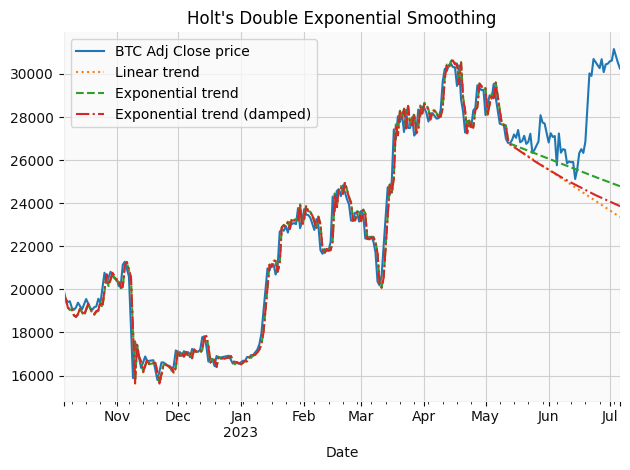

In [30]:
hs_df = data.copy()
hs_df["hs_1"] = pd.concat([hs_1.fittedvalues,hs_forecast_1])
hs_df["hs_2"] = pd.concat([hs_2.fittedvalues,hs_forecast_2])
hs_df["hs_3"] = pd.concat([hs_3.fittedvalues,hs_forecast_3])

fig, ax = plt.subplots()
hs_df[['Adj Close','hs_1','hs_2','hs_3']].plot(style=["-",":","--", "-."], ax=ax,
                    title="Holt's Double Exponential Smoothing")
labels = [
    "BTC Adj Close price",
    "Linear trend",
    "Exponential trend",
    "Exponential trend (damped)",
]
ax.legend(labels)

sns.despine()
plt.tight_layout()

In [31]:
SEASONAL_PERIODS = 7

# Holt-Winters' model with exponential trend
hw_1 = ExponentialSmoothing(df_train,
                            trend="mul",
                            seasonal="add",
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_len)

# Holt-Winters' model with exponential trend and damping
hw_2 = ExponentialSmoothing(df_train,
                            trend="mul",
                            seasonal="add",
                            seasonal_periods=SEASONAL_PERIODS,
                            damped_trend=True).fit()
hw_forecast_2 = hw_2.forecast(test_len)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [32]:
hw_2.params_formatted

,name,param,optimized
smoothing_level,alpha,0.995000,True
smoothing_trend,beta,0.035536,True
smoothing_seasonal,gamma,0.005000,True
initial_level,l.0,19311.622675,True
initial_trend,b.0,0.999499,True
damping_trend,phi,0.990000,True
initial_seasons.0,s.0,-185.469119,True
initial_seasons.1,s.1,54.400022,True
initial_seasons.2,s.2,141.690828,True
initial_seasons.3,s.3,214.238680,True


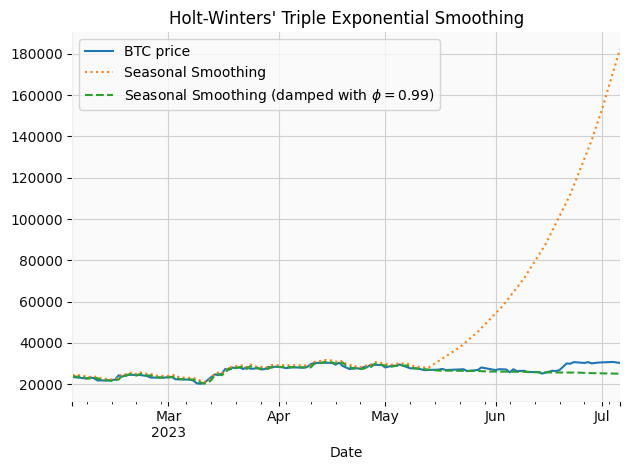

In [33]:
hw_df = data.copy()
hw_df["hw_1"] = pd.concat([hw_1.fittedvalues,hw_forecast_1])
hw_df["hw_2"] = pd.concat([hw_2.fittedvalues,hw_forecast_2])

fig, ax = plt.subplots()
hw_df = hw_df[hw_df.index>'2023-02']
hw_df[['Adj Close','hw_1','hw_2']].plot(
    style=["-",":","--"], ax=ax,
    title="Holt-Winters' Triple Exponential Smoothing"
)
phi = hw_2.model.params["damping_trend"]

labels = [
    "BTC price",
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)"
]
ax.legend(labels)

sns.despine()
plt.tight_layout()

## Auto ETS

In [34]:
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_absolute_percentage_error

In [35]:
auto_ets = AutoETS(auto=True, n_jobs=-1, sp=7)
auto_ets.fit(df_train.to_period())
auto_ets_fcst = auto_ets.predict(fh=list(range(1, 13)))


In [36]:
print(auto_ets.summary())

                                 ETS Results                                  
Dep. Variable:              Adj Close   No. Observations:                  219
Model:                       ETS(MNN)   Log Likelihood               -1706.535
Date:                Thu, 06 Jul 2023   AIC                           3419.070
Time:                        17:34:40   BIC                           3429.238
Sample:                    10-06-2022   HQIC                          3423.177
                         - 05-12-2023   Scale                            0.001
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.067     14.959      0.000       0.869       1.131
initial_level    1.972e+04    525.197     37.554      0.000    1.87e+04    2.08e+04
Ljung-Box (Q):                  

<ipython-input-37-fec1b09f994d>:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(auto_ets_fcst)


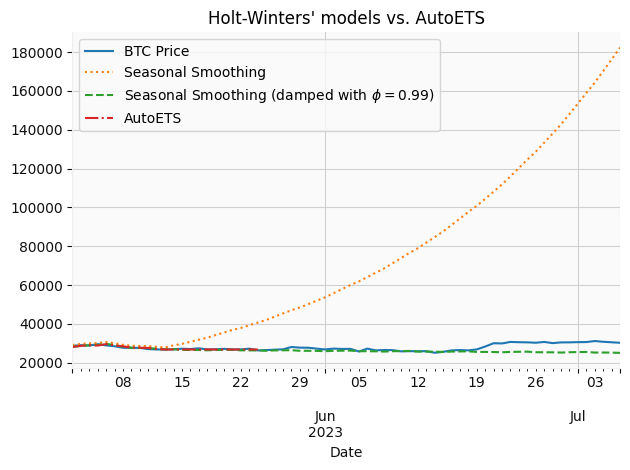

In [37]:
auto_ets_df = hw_df.to_period().copy()
auto_ets_df["auto_ets"] = (
    auto_ets
    ._fitted_forecaster
    .fittedvalues
    .append(auto_ets_fcst)
)

fig, ax = plt.subplots()
auto_ets_df=auto_ets_df[auto_ets_df.index>'2023-05']
auto_ets_df[['Adj Close','hw_1','hw_2','auto_ets']].plot(
    style=["-",":","--","-."], ax=ax,
    title="Holt-Winters' models vs. AutoETS"
)
labels = [
    "BTC Price",
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)",
    "AutoETS",
]
ax.legend(labels)

sns.despine()
plt.tight_layout()

## Modeling time series with ARIMA class models

In [38]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [39]:
import math
(math.e ** np.log(data['Adj Close']/data['Adj Close'].shift(1)).sum())*19955.44

30251.50857922052

In [40]:
train_size = int(0.8 * len(data['Adj Close'].dropna()))
test_len = len(data['Adj Close'].dropna())-train_size
df_train = data.iloc[:train_size]
df_test = data.iloc[train_size:]
len(df_train), len(df_test)

(219, 55)

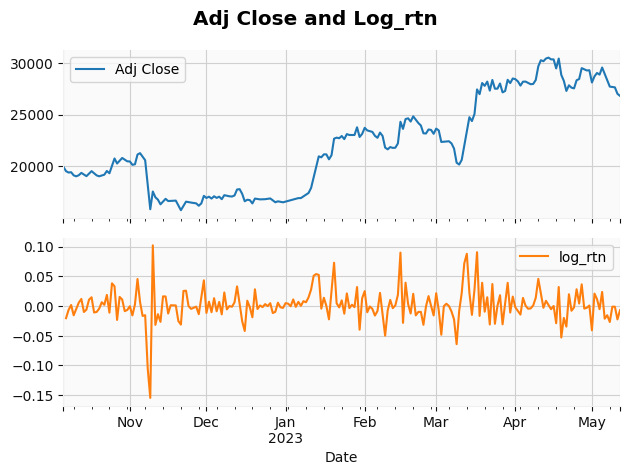

In [41]:
df_train[['Adj Close','log_rtn']].plot(subplots=True,
                                       title='Adj Close and Log_rtn')

sns.despine()
plt.tight_layout()

In [42]:
arima_111 = ARIMA(
    df_train['log_rtn'],order=(1,1,1)
).fit()
print(arima_111.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                log_rtn   No. Observations:                  219
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 463.642
Date:                Thu, 06 Jul 2023   AIC                           -921.283
Time:                        17:34:45   BIC                           -911.130
Sample:                    10-06-2022   HQIC                          -917.182
                         - 05-12-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0685      0.030      2.271      0.023       0.009       0.128
ma.L1         -0.9999      2.745     -0.364      0.716      -6.379       4.379
sigma2         0.0007      0.002      0.366      0.7

In [73]:
arima_202 = ARIMA(
    df_train["log_rtn"], order=(2, 0, 2)
).fit()
print(arima_212.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                log_rtn   No. Observations:                  219
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 476.897
Date:                Thu, 06 Jul 2023   AIC                           -941.795
Time:                        17:40:34   BIC                           -921.460
Sample:                    10-06-2022   HQIC                          -933.582
                         - 05-12-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.601      0.548      -0.003       0.006
ar.L1          0.1914      7.886      0.024      0.981     -15.265      15.648
ar.L2          0.1654      3.338      0.050      0.9

In [68]:
data['pred_111_log_rtn']= pd.concat([df_train['log_rtn'], arima_111.forecast(test_len)])

forecast = arima_111.forecast(test_len)
pred_price_list = np.exp(data['pred_111_log_rtn'].cumsum())

data['pred_111'] = np.array(pred_price_list)* data['Adj Close'][0]
data['pred_111'].tail()

Date
2023-07-02    28687.491401
2023-07-03    28726.052461
2023-07-04    28764.665354
2023-07-05    28803.330150
2023-07-06    28842.046917
Name: pred_111, dtype: float64

In [74]:
data['pred_202_log_rtn']= pd.concat([df_train["log_rtn"], arima_202.forecast(test_len)])

forecast = arima_202.forecast(test_len)
pred_price_list = np.exp(data['pred_212_log_rtn'].cumsum())

data['pred_202'] = np.array(pred_price_list)* data['Adj Close'][0]
data['pred_202'].tail(),data['Adj Close'][-1]

(Date
 2023-07-02    28616.712101
 2023-07-03    28654.685923
 2023-07-04    28692.710134
 2023-07-05    28730.784804
 2023-07-06    28768.909997
 Name: pred_202, dtype: float64,
 30251.513671875)

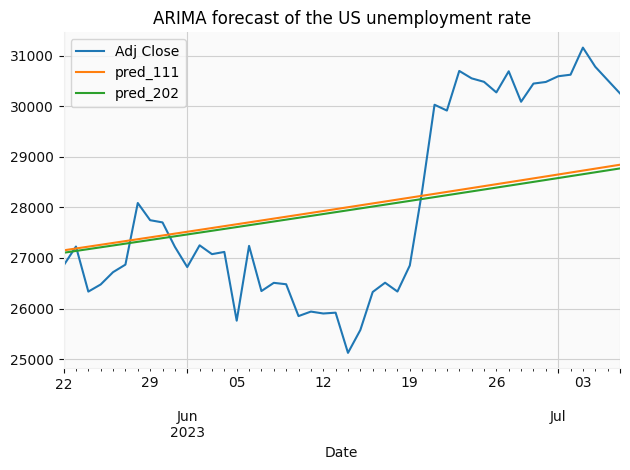

In [75]:
latest_data = data[data.index>'2023-05-20']


(
    latest_data[["Adj Close", "pred_111", "pred_202"]]
    .iloc[1:]
    .plot(title="ARIMA forecast of the US unemployment rate")
);

sns.despine()
plt.tight_layout()

In [76]:
mape_111 = mean_absolute_percentage_error(
    data["Adj Close"].iloc[-test_len:],
    data["pred_111"].iloc[-test_len:]
)

mape_202 = mean_absolute_percentage_error(
    data["Adj Close"].iloc[-test_len:],
    data["pred_202"].iloc[-test_len:]
)

print(f"MAPE of ARIMA(1,1,1): {100 * mape_111:.2f}%")
print(f"MAPE of ARIMA(2,0,2): {100 * mape_202:.2f}%")



MAPE of ARIMA(1,1,1): 4.23%
MAPE of ARIMA(2,0,2): 4.22%
